
# Introduction to PyTorch Lightning

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2023-05-03T17:23:23.973569

In this notebook, we'll go over the basics of lightning by preparing models to train on the [MNIST Handwritten Digits dataset](https://en.wikipedia.org/wiki/MNIST_database).

---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/mnist-hello-world.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "pytorch-lightning>=1.4, <2.1.0" "torchvision" "setuptools==67.7.2" "lightning>=2.0.0rc0" "seaborn" "torchmetrics>=0.7, <0.12" "matplotlib>=3.0.0, <3.8.0" "torchmetrics >=0.11.0" "pandas" "torch>=1.8.1, <2.1.0" "ipython[notebook]>=8.0.0, <8.14.0" "urllib3"

In [2]:

# ------------------- Preliminaries ------------------- #
import os
from dataclasses import dataclass
from typing import Tuple

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# ------------------- Configuration ------------------- #


@dataclass
class Config:
    """Configuration options for the Lightning MNIST example.

    Args:
        data_dir : The path to the directory where the MNIST dataset is stored. Defaults to the value of
            the 'PATH_DATASETS' environment variable or '.' if not set.

        save_dir : The path to the directory where the training logs will be saved. Defaults to 'logs/'.

        batch_size : The batch size to use during training. Defaults to 256 if a GPU is available,
            or 64 otherwise.

        max_epochs : The maximum number of epochs to train the model for. Defaults to 3.

        accelerator : The accelerator to use for training. Can be one of "cpu", "gpu", "tpu", "ipu", "auto".

        devices : The number of devices to use for training. Defaults to 1.

    Examples:
        This dataclass can be used to specify the configuration options for training a PyTorch Lightning model on the
        MNIST dataset. A new instance of this dataclass can be created as follows:

        >>> config = Config()

        The default values for each argument are shown in the documentation above. If desired, any of these values can be
        overridden when creating a new instance of the dataclass:

        >>> config = Config(batch_size=128, max_epochs=5)
    """

    data_dir: str = os.environ.get("PATH_DATASETS", ".")
    save_dir: str = "logs/"
    batch_size: int = 256 if torch.cuda.is_available() else 64
    max_epochs: int = 3
    accelerator: str = "auto"
    devices: int = 1


config = Config()

## Simplest example

Here's the simplest most minimal example with just a training loop (no validation, no testing).

**Keep in Mind** - A `LightningModule` *is* a PyTorch `nn.Module` - it just has a few more helpful features.

In [3]:


class MNISTModel(L.LightningModule):
    """A PyTorch Lightning module for classifying images in the MNIST dataset.

    Attributes:
        l1 : A linear layer that maps input features to output features.

    Methods:
        forward(x):
            Performs a forward pass through the model.

        training_step(batch, batch_nb):
            Defines a single training step for the model.

        configure_optimizers():
            Configures the optimizer to use during training.

    Examples:
        The MNISTModel class can be used to create and train a PyTorch Lightning model for classifying images in the MNIST
        dataset. To create a new instance of the model, simply instantiate the class:

        >>> model = MNISTModel()

        The model can then be trained using a PyTorch Lightning trainer object:

        >>> trainer = pl.Trainer()
        >>> trainer.fit(model)
    """

    def __init__(self):
        """Initializes a new instance of the MNISTModel class."""
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the model.

        Args:
            x : The input tensor to pass through the model.

        Returns:
            activated : The output tensor produced by the model.

        Examples:
            >>> model = MNISTModel()
            >>> x = torch.randn(1, 1, 28, 28)
            >>> output = model(x)
        """
        flattened = x.view(x.size(0), -1)
        hidden = self.l1(flattened)
        activated = torch.relu(hidden)

        return activated

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> torch.Tensor:
        """Defines a single training step for the model.

        Args:
            batch: A tuple containing the input and target tensors for the batch.
            batch_nb: The batch number.

        Returns:
            torch.Tensor: The loss value for the current batch.

        Examples:
            >>> model = MNISTModel()
            >>> x = torch.randn(1, 1, 28, 28)
            >>> y = torch.tensor([1])
            >>> loss = model.training_step((x, y), 0)
        """
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configures the optimizer to use during training.

        Returns:
            torch.optim.Optimizer: The optimizer to use during training.

        Examples:
            >>> model = MNISTModel()
            >>> optimizer = model.configure_optimizers()
        """
        return torch.optim.Adam(self.parameters(), lr=0.02)

By using the `Trainer` you automatically get:
1. Tensorboard logging
2. Model checkpointing
3. Training and validation loop
4. early-stopping

In [4]:
# Init our model
mnist_model = MNISTModel()

# Init DataLoader from MNIST Dataset
train_ds = MNIST(config.data_dir, train=True, download=True, transform=transforms.ToTensor())

# Create a dataloader
train_loader = DataLoader(train_ds, batch_size=config.batch_size)

# Initialize a trainer
trainer = L.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
)

# Train the model ⚡
trainer.fit(mnist_model, train_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

 43%|████▎     | 4259840/9912422 [00:00<00:00, 42547719.74it/s]

 94%|█████████▎| 9273344/9912422 [00:00<00:00, 46930271.15it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 46261234.08it/s]

Extracting /__w/8/s/.datasets/MNIST/raw/train-images-idx3-ubyte.gz to /__w/8/s/.datasets/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

100%|██████████| 28881/28881 [00:00<00:00, 34979986.67it/s]

Extracting /__w/8/s/.datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /__w/8/s/.datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

100%|██████████| 1648877/1648877 [00:00<00:00, 23129684.78it/s]

Extracting /__w/8/s/.datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /__w/8/s/.datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

100%|██████████| 4542/4542 [00:00<00:00, 8058599.31it/s]

Extracting /__w/8/s/.datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /__w/8/s/.datasets/MNIST/raw



GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: /__w/8/s/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]



  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## A more complete MNIST Lightning Module Example

That wasn't so hard was it?

Now that we've got our feet wet, let's dive in a bit deeper and write a more complete `LightningModule` for MNIST...

This time, we'll bake in all the dataset specific pieces directly in the `LightningModule`.
This way, we can avoid writing extra code at the beginning of our script every time we want to run it.

---

### Note what the following built-in functions are doing:

1. [prepare_data()](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#prepare-data) 💾
    - This is where we can download the dataset. We point to our desired dataset and ask torchvision's `MNIST` dataset class to download if the dataset isn't found there.
    - **Note we do not make any state assignments in this function** (i.e. `self.something = ...`)

2. [setup(stage)](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#setup) ⚙️
    - Loads in data from file and prepares PyTorch tensor datasets for each split (train, val, test).
    - Setup expects a 'stage' arg which is used to separate logic for 'fit' and 'test'.
    - If you don't mind loading all your datasets at once, you can set up a condition to allow for both 'fit' related setup and 'test' related setup to run whenever `None` is passed to `stage` (or ignore it altogether and exclude any conditionals).
    - **Note this runs across all GPUs and it *is* safe to make state assignments here**

3. [x_dataloader()](https://lightning.ai/docs/pytorch/stable/api/pytorch_lightning.core.hooks.DataHooks.html#pytorch_lightning.core.hooks.DataHooks.train_dataloader) ♻️
    - `train_dataloader()`, `val_dataloader()`, and `test_dataloader()` all return PyTorch `DataLoader` instances that are created by wrapping their respective datasets that we prepared in `setup()`

In [5]:


class LitMNIST(L.LightningModule):
    """PyTorch Lightning module for training a multi-layer perceptron (MLP) on the MNIST dataset.

    Attributes:
        data_dir : The path to the directory where the MNIST data will be downloaded.

        hidden_size : The number of units in the hidden layer of the MLP.

        learning_rate : The learning rate to use for training the MLP.

    Methods:
        forward(x):
            Performs a forward pass through the MLP.

        training_step(batch, batch_idx):
            Defines a single training step for the MLP.

        validation_step(batch, batch_idx):
            Defines a single validation step for the MLP.

        test_step(batch, batch_idx):
            Defines a single testing step for the MLP.

        configure_optimizers():
            Configures the optimizer to use for training the MLP.

        prepare_data():
            Downloads the MNIST dataset.

        setup(stage=None):
            Splits the MNIST dataset into train, validation, and test sets.

        train_dataloader():
            Returns a DataLoader for the training set.

        val_dataloader():
            Returns a DataLoader for the validation set.

        test_dataloader():
            Returns a DataLoader for the test set.
    """

    def __init__(self, data_dir: str = config.data_dir, hidden_size: int = 64, learning_rate: float = 2e-4):
        """Initializes a new instance of the LitMNIST class.

        Args:
            data_dir : The path to the directory where the MNIST data will be downloaded. Defaults to config.data_dir.

            hidden_size : The number of units in the hidden layer of the MLP (default is 64).

            learning_rate : The learning rate to use for training the MLP (default is 2e-4).
        """
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the MLP.

        Args:
            x : The input data.

        Returns:
            torch.Tensor: The output of the MLP.
        """
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> torch.Tensor:
        """Defines a single training step for the MLP.

        Args:
            batch: A tuple containing the input data and target labels.

            batch_idx: The index of the current batch.

        Returns:
            (torch.Tensor): The training loss.
        """
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        """Defines a single validation step for the MLP.

        Args:
            batch : A tuple containing the input data and target labels.
            batch_idx : The index of the current batch.
        """
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        """Defines a single testing step for the MLP.

        Args:
            batch : A tuple containing the input data and target labels.
            batch_idx : The index of the current batch.
        """
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configures the optimizer to use for training the MLP.

        Returns:
            torch.optim.Optimizer: The optimizer.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer

    # ------------------------------------- #
    # DATA RELATED HOOKS
    # ------------------------------------- #

    def prepare_data(self) -> None:
        """Downloads the MNIST dataset."""
        MNIST(self.data_dir, train=True, download=True)

        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str = None) -> None:
        """Splits the MNIST dataset into train, validation, and test sets.

        Args:
            stage : The current stage (either "fit" or "test"). Defaults to None.
        """
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)

            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the training set.

        Returns:
            DataLoader: The training DataLoader.
        """
        return DataLoader(self.mnist_train, batch_size=config.batch_size)

    def val_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the validation set.

        Returns:
            DataLoader: The validation DataLoader.
        """
        return DataLoader(self.mnist_val, batch_size=config.batch_size)

    def test_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the test set.

        Returns:
            DataLoader: The test DataLoader.
        """
        return DataLoader(self.mnist_test, batch_size=config.batch_size)

In [6]:
# Instantiate the LitMNIST model
model = LitMNIST()

# Instantiate a PyTorch Lightning trainer with the specified configuration
trainer = L.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
    logger=CSVLogger(save_dir=config.save_dir),
)

# Train the model using the trainer
trainer.fit(model)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: logs/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]



  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Testing

To test a model, call `trainer.test(model)`.

Or, if you've just trained a model, you can just call `trainer.test()` and Lightning will automatically
test using the best saved checkpoint (conditioned on val_loss).

In [7]:
trainer.test(ckpt_path="best")

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]


Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9240000247955322     │
│         test_loss         │    0.26174187660217285    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.26174187660217285, 'test_acc': 0.9240000247955322}]

### Bonus Tip

You can keep calling `trainer.fit(model)` as many times as you'd like to continue training

In [8]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]



  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In Colab, you can use the TensorBoard magic function to view the logs that Lightning has created for you!

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.440236,0.8892,NaN,NaN
1,0.316530,0.9124,NaN,NaN
2,0.271723,0.9212,NaN,NaN
3,NaN,NaN,0.261742,0.924


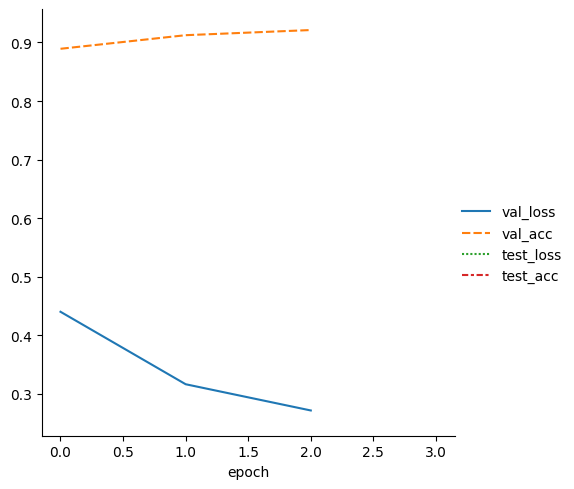

In [9]:

# Read in the training metrics from the CSV file generated by the logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Remove the "step" column, which is not needed for our analysis
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace=True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis=1, how="all").head())

# Create a line plot of the training metrics using Seaborn
sn.relplot(data=metrics, kind="line")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)